### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1) $$-\frac{dL}{da} = 2 (y_i-a(x_i))^2$$ \
2) $$-\frac{dL}{da} = y_i exp(-a(x_i)y_i)$$ \
3) $$-\frac{dL}{da} = \frac{y_i exp(-a(x_i)y_i)}{1 + exp(-a(x_i)y_i)}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций \
б) размер шага \
в) процент случайных фичей при построении одного дерева \
д) процент случайных объектов при построении одного дерева \
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

np.random.seed(42)

In [29]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=0.01, n_estimators=100, 
                 colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.params = args
        self.kwparams = kwargs
        self.models = []
        self.features = []
        if loss == 'MSE':
            self.__loss = lambda true, pred: (true - pred) ** 2
            self.__grad = lambda true, pred: 2 * (true - pred)
        elif loss == 'exp':
            self.__loss = lambda true, pred: np.exp(-true * pred)
            self.__grad = lambda true, pred: true * np.exp(-true * pred)
        elif loss == 'log':
            self.__loss = lambda true, pred: np.log(1 + np.exp(-pred * true))
            self.__grad = lambda true, pred: true * np.exp(-true * pred) /\
                                             (1 + np.exp(-pred * true))
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        if init_model is None:
            self.init_model = None
            pred = np.ones(X.shape[0]) / X.shape[0]
        else:
            model = init_model()
            model.fit(X, y)
            self.init_model = model
            pred = model.predict(X)
            pred = pred.astype(float)
        
        for i in range(self.n_estimators):
            features_num = int(self.colsample * X.shape[1])
            features = np.random.randint(0, X.shape[1], size=features_num)
            objects_num = int(self.subsample * X.shape[0])
            objects = np.random.randint(0, X.shape[0], size=objects_num)

            model = base_model(*self.params, **self.kwparams)
            X_iter = X[objects]
            model.fit(X_iter[:, features], self.__grad(y[objects], pred[objects]))

            pred += self.learning_rate * model.predict(X[:, features])
            self.models.append(model)
            self.features.append(features)
        
    def predict(self, X):
        # Ваш код здесь
        if self.init_model is None:
            pred = np.ones(X.shape[0]) / X.shape[0]
        else:
            pred = self.init_model.predict(X).astype(float)
            
        for i in range(len(self.models)):
            pred += self.learning_rate * self.models[i].predict(X[:, self.features[i]])
        return np.round(pred)


In [3]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.2, 
                                                    stratify=wine.target, random_state=42)

In [4]:
clf = GradientBoostingClassifier()
my_clf = MyGradientBoostingClassifier()

clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9722222222222222


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [5]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [6]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


Будем искать оптимальные параметры на валидации отдельно друг от друга, поскольку полный перебор занимает много времени

In [7]:
best_params = {}

In [8]:
score = []
grid = np.arange(10, 150, 30)
for n_estimators in grid:
    est_score = []
    for train, val in KFold(n_splits=3, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=n_estimators)
        my_clf.fit(X[train], y[train])
        est_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(est_score))
    score.append(np.mean(est_score))

best_params['n_estimators'] = grid[np.argmax(score)]

0.5780523255813953
0.7267926356589148
0.8651162790697674
0.8865310077519379
0.8900193798449613


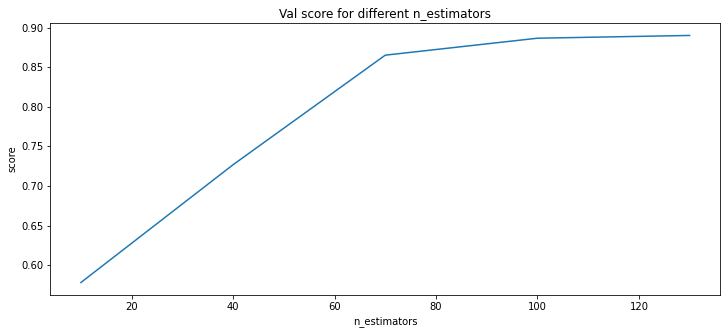

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(grid, score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Val score for different n_estimators')
plt.show()

При дальнейшем увеличении количества n_estimators скор будет расти медленно и обучение будет происходить существенно дольше. Выберем оптимальный вариант между качеством и скоростью работы.

In [10]:
score = []
grid = ['MSE', 'exp', 'log']
for loss in grid:
    est_score = []
    for train, val in KFold(n_splits=3, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=best_params['n_estimators'],
                                              loss=loss)
        my_clf.fit(X[train], y[train])
        est_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(est_score))
    score.append(np.mean(est_score))

best_params['loss'] = grid[np.argmax(score)]

0.8906492248062016
0.8839147286821705
0.7205910852713178


In [11]:
score = []
grid = [0.005, 0.01, 0.05, 0.1, 0.5]
for lr in grid:
    est_score = []
    for train, val in KFold(n_splits=3, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=best_params['n_estimators'],
                                              loss=best_params['loss'],
                                              learning_rate=lr)
        my_clf.fit(X[train], y[train])
        est_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(est_score))
    score.append(np.mean(est_score))

best_params['learning_rate'] = grid[np.argmax(score)]

0.855765503875969
0.8890019379844961
0.8772286821705427
0.8669573643410852
0.5255813953488372


In [12]:
score = []
grid = [1, 0.75, 0.5, 0.25]
for cols in grid:
    est_score = []
    for train, val in KFold(n_splits=3, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=best_params['n_estimators'],
                                              loss=best_params['loss'],
                                              learning_rate=best_params['learning_rate'],
                                              colsample=cols)
        my_clf.fit(X[train], y[train])
        est_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(est_score))
    score.append(np.mean(est_score))

best_params['colsample'] = grid[np.argmax(score)]

0.8896802325581395
0.8905038759689923
0.8749515503875968
0.8238856589147288


In [13]:
score = []
grid = [1, 0.75, 0.5, 0.25]
for subs in grid:
    est_score = []
    for train, val in KFold(n_splits=3, shuffle=True).split(X, y):
        my_clf = MyGradientBoostingClassifier(n_estimators=best_params['n_estimators'],
                                              loss=best_params['loss'],
                                              learning_rate=best_params['learning_rate'],
                                              colsample=best_params['colsample'],
                                              subsample=subs)
        my_clf.fit(X[train], y[train])
        est_score.append(accuracy_score(y[val], my_clf.predict(X[val])))
    print(np.mean(est_score))
    score.append(np.mean(est_score))

best_params['subsample'] = grid[np.argmax(score)]

0.8900193798449613
0.8898740310077519
0.8903100775193798
0.8861918604651162


In [2]:
best_params

{'colsample': 0.75,
 'learning_rate': 0.01,
 'loss': 'MSE',
 'n_estimators': 130,
 'subsample': 0.5}

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

my_clf = MyGradientBoostingClassifier(**best_params)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(y_test, my_clf.predict(X_test))

0.8874354005167958

In [17]:
N = 100
pred = np.zeros(y_test.shape)
for i in range(N):
    objects = np.random.randint(0, X_train.shape[0], size=X_train.shape[0] // N)
    my_clf = MyGradientBoostingClassifier(**best_params)
    my_clf.fit(X_train[objects], y_train[objects])
    pred += my_clf.predict(X_test)
accuracy_score(y_test, (pred / N)  >= 0.5)

0.8347868217054264

Значительно улучшить качество с помощью первой модели (BooBag) не получилось. Хотя случайный лес хорошо подстраивается под выборку, но все равно скор примерно такой же, как и для классификатора с base_model=DecisionTreeClassifier. Получается, что обобщающая способность обычных деревьев не хуже, а в данном случае может и лучше, чем случайного леса. 

Вторая модель (BagBoo) показала скор хуже, чем один классификатор, так как каждую итерацию мы обучаем одну и ту же модель только на разных данных (возможно, ей недостаточно данных для того, чтобы подстроиться под всю выборку).

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [18]:
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [19]:
my_clf = MyGradientBoostingClassifier(**best_params)
my_clf.fit(X_train, y_train, init_model=LinearRegression)
accuracy_score(y_test, my_clf.predict(X_test))

0.8968023255813954

In [20]:
my_clf = MyGradientBoostingClassifier(**best_params)
my_clf.fit(X_train, y_train, init_model=SGDClassifier)
accuracy_score(y_test, my_clf.predict(X_test))

0.8864664082687338

In [21]:
my_clf = MyGradientBoostingClassifier(**best_params)
my_clf.fit(X_train, y_train, init_model=LinearSVC)
accuracy_score(y_test, my_clf.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8662790697674418

In [22]:
my_clf = MyGradientBoostingClassifier(**best_params)
my_clf.fit(X_train, y_train, init_model=DecisionTreeClassifier)
accuracy_score(y_test, my_clf.predict(X_test))

0.8229974160206718

In [30]:
my_clf = MyGradientBoostingClassifier(**best_params)
my_clf.fit(X_train, y_train, init_model=KNeighborsClassifier)
accuracy_score(y_test, my_clf.predict(X_test))

0.6356589147286822

Получилось улучшить предикт в случае, если использовать LinearRegression. Остальные классификаторы не дали значимого прироста.

Инициализирующая модель существенно влияет на качество предсказания, так как разные модели по-разному описывают данные. Если начать с предикта, который лучше всего подходит для наших данных, то можно быстро прийти к высокому скору на валидации (LinearRegression), и наоборот, плохое начальное предсказание может даже не привести к желаемому качеству модели (например, KNeighborsClassifier).

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

